        MTOW: 362485 lbs                    OEW: 151177 lbs


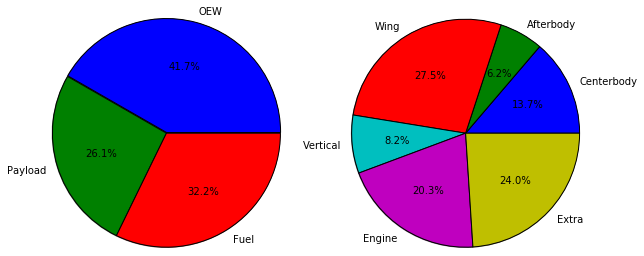

In [4]:
m.controlpanel(fn_of_sol=Weights_pie)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from gpkit import VectorVariable, Variable, Model, units
from gpkit.tools import te_exp_minus1
import gpkit
import numpy as np
from gpkit.constraints.set import ConstraintSet
import subprocess


def Weights_pie(sol):
    Wts = sol.program.result["variables"]
    print "        " + "MTOW: %.0f lbs" %(Wts["W_{MTO}"]) + "                    " + "OEW: %.0f lbs" %(Wts["W_{ZF}"])


    the_grid = plt.GridSpec(1, 8)

    plt.subplot(the_grid[0, 0], aspect=1)

    plt.pie([Wts["W_{ZF}"],Wts["W_{payload}"],Wts["W_{fuel}"]], 
            labels=['OEW','Payload','Fuel'],
            explode=(0.05, 0, 0),
            autopct='%1.1f%%', shadow=True, radius=8.0)

    plt.subplot(the_grid[0, 7], aspect=1)

    plt.pie([Wts["W_{CB}"], Wts["W_{AF}"], Wts["W_{wing}"], Wts["W_{vertical}"], Wts["n_{eng}"]*Wts["W_{eng}"], Wts["W_{extra}"]], 
            labels=['Centerbody','Afterbody','Wing','Vertical','Engine','Extra'],
            explode=(0, 0, 0, 0, 0, 0),
            autopct='%1.1f%%', shadow=True, radius=8.0)
    


SFC = Variable("SFC", 0.55, "lbs/lbs/hr", "Specific Fuel Consumption")
R = Variable("R", 8000, "nmi", "Range")
V = Variable("V", 290, "m/s", "Velocity")
# rho = Variable("\\rho", 1.23, "kg/m^3", "Air Density")
rho = Variable("\\rho", 0.3, "kg/m^3", "Air Density")
S = Variable("S", 800, "m^2", "Wing Area")
n_eng = Variable("n_{eng}", 2, "-", "Number of Engines")
lambda_aft = Variable("\\lambda_{aft}", 0.8, "-", "Aftbody Taper Ratio")
n_pax = Variable("n_{pax}", 450, "-", "Number of Passengers")
W_pax = Variable("W_{pax}", 210, "lbf", "Weight of One Passenger")
pi = Variable("\\pi", np.pi, "-", "pi")
e = Variable("e", 0.9, "-", "Oswald Efficiency")
AR = Variable("AR", 7.0, "-", "Aspect Ratio")

MTOW = Variable("W_{MTO}", "lbf", "Maximum Takeoff Weight")
z_bre = Variable("z_{bre}", "-", "Breguet Term")
L = Variable("L", "lbf", "Lift")
CL = Variable("C_L", "-", "Lift Coefficient")
D = Variable("D", "lbf", "Drag")
CD = Variable("C_D", "-", "Drag Coefficient")
CDp = Variable("C_Dp", "-", "Profile Drag Coefficient")
ZFW = Variable("W_{ZF}", "lbf", "Zero Fuel Weight")

W_cb = Variable("W_{CB}", "lbf", "Centerbody Weight")
cabin_area = Variable("S_{cabin}", "m^2", "Cabin Planform Area")
W_af = Variable("W_{AF}", "lbf", "Afterbody Weight")
aft_area = Variable("S_{aft}", "m^2", "Cabin Planform Area")
W_wing = Variable("W_{wing}", "lbf", "Wing Weight")
W_vertical = Variable("W_{vertical}", "lbf", "Vertical Tail Weight")
W_pay = Variable("W_{payload}", "lbf", "Payload Weight")
W_fuel = Variable("W_{fuel}", "lbf", "Fuel Weight")
W_eng = Variable("W_{eng}", "lbf", "Engine Weight")
W_extra = Variable("W_{extra}", "lbf", "Additional Weight")

# Performance Model
constraints = [0.5 * rho * V**2 * CL * S >= MTOW,
               L == MTOW,
               D >= 1./2 * rho * V**2 * CD * S,
               z_bre >= R * (SFC/V) * (D/L),
               W_fuel >= ZFW*te_exp_minus1(z_bre,4)]

# Aero Model
class XFOIL():
    def __init__(self):
        self.pathname = "/Users/codykarcher/Xfoil/bin/./xfoil"
        
    def cd_model(self, x0, max_iter=100):

        # File XFOIL will save data to
        polarfile = 'polars.txt'
        
        # Remove any existing file.  Prevents XFOIL Error
        ls_res = subprocess.check_output(["ls -a"], shell = True)
        ls = ls_res.split()
        if polarfile in ls_res:
            subprocess.call("rm " + polarfile, shell = True)

        # Open XFOIL and run case
        proc = subprocess.Popen([self.pathname], 
                                         stdout=subprocess.PIPE, stdin=subprocess.PIPE)
        proc.stdin.write('naca2412 \n' + 
                         'oper \n' +
                         "iter %d\n" %(max_iter)+
                         'visc \n' +
                         "%.0f \n" % (1.0e6) + #(x0["Re"]) +
                         'pacc \n' +
                         '\n' +
                         '\n' +
                         "cl %.0f \n" %(x0["C_L"]) +
                         'pwrt \n' +
                         polarfile +
                         '\n' +
                         'q')
        stdout_val = proc.communicate()[0]
        proc.stdin.close()

        # Read data from XFOIL output
        data = np.genfromtxt(polarfile, skip_header=12)
        CD_star = data[2]
        
        return CD_star

class SimpleCDModel(ConstraintSet):
    
    def as_posyslt1(self):
        raise ValueError("SimpleCDModel is not allowed to solve as a GP.")
        
    def as_gpconstr(self, x0):
        if not x0:
            return (CDp >= 0.01)
        else:
            xfoilcd = XFOIL().cd_model(x0)
        return (CDp >= xfoilcd)

constraints += [SimpleCDModel([]),
                CD >= CDp + 5.*(CL**2)/(pi*e*AR)]
# constraints += [CD >= Aero_Model]


# Weights Model
wcb_mtow_exp = 0.166552
wcb_ca_exp = 1.061158
constraints += [ZFW >= (W_cb + W_af + W_wing + W_vertical +  n_eng*W_eng + W_extra),
                W_cb >= 3.*(units.lbf * units.lbf**(-wcb_mtow_exp) * units.meters**(-2*wcb_ca_exp)) * (
                                     5.698865 * 0.316422 * (MTOW ** wcb_mtow_exp) * cabin_area ** wcb_ca_exp),
                cabin_area == 0.4*S,
                W_af >= 6.*(units.lbf * units.lbf**(-.2) * units.meter**(-2))*(
                                     (1.0 + 0.05*n_eng) * 0.53 * aft_area * (MTOW**0.2) * (lambda_aft + 0.5) ),
                aft_area == 0.2*S,
                W_wing >= 2.*W_cb,
                W_vertical >= .3*W_wing,
                W_pay >= n_pax*W_pax,
                MTOW >= ZFW + W_pay + W_fuel,
                W_eng >= .5*D,
                W_extra >= .1*MTOW
               ]

objective = MTOW

m = Model(objective, constraints)

# m.controlpanel(fn_of_sol=Weights_pie)
sol=m.localsolve()


Beginning signomial solve.
Solving took 3 GP solves and 0.336 seconds.

Cost
----
 3.928e+05 [lbf] 

Free Variables
--------------
         C_D : 0.01425           Drag Coefficient        
        C_Dp : 0.00668           Profile Drag Coefficient
         C_L : 0.1731            Lift Coefficient        
           D : 3.233e+04  [lbf]  Drag                    
           L : 3.928e+05  [lbf]  Lift                    
     S_{aft} : 160        [m**2] Cabin Planform Area     
   S_{cabin} : 320        [m**2] Cabin Planform Area     
      W_{AF} : 9566       [lbf]  Afterbody Weight        
      W_{CB} : 2.105e+04  [lbf]  Centerbody Weight       
     W_{MTO} : 3.928e+05  [lbf]  Maximum Takeoff Weight  
      W_{ZF} : 1.57e+05   [lbf]  Zero Fuel Weight        
     W_{eng} : 1.617e+04  [lbf]  Engine Weight           
   W_{extra} : 3.928e+04  [lbf]  Additional Weight       
    W_{fuel} : 1.413e+05  [lbf]  Fuel Weight             
 W_{payload} : 9.45e+04   [lbf]  Payload Weight          